In [ ]:
import pandas as pd
import numpy as np

In [ ]:
dataset = pd.read_csv('/content/labeled_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/labeled_data.csv'

## How to Train Model:
Remove stopwords, stemm, lemm, stratify according to 0 to get equal instances of both non-hateful and hateful speech, make sure to convert 2 to 1

Step 1: Make sure everything is in UTF-8

In [ ]:
def omit_non_utf8_lines(input_file, output_file):
    with open(input_file, 'rb') as infile, open(output_file, 'wb') as outfile:
        for line in infile:
            try:
                # Try to decode the line with UTF-8
                line.decode('utf-8')
                # If successful, write the line to the output file
                outfile.write(line)
            except UnicodeDecodeError:
                # If a UnicodeDecodeError occurs, skip the line
                continue

# Example usage
input_file = '/content/labeled_data.csv'
output_file = 'cleaned_file.csv'

In [ ]:
omit_non_utf8_lines(input_file, output_file)

In [ ]:
hate = pd.read_csv('/content/cleaned_file.csv')

## Conduct Train Test Split


In [ ]:
#Change the Labels
hate['class'] = hate['class'].replace({1:0})
hate['class'] = hate['class'].replace({2:1})

In [ ]:
from sklearn.model_selection import train_test_split
X = hate['tweet']
y = hate['class']


# Assuming df is your original DataFrame
df_label_1 = hate[hate['class'] == 1]
df_label_0 = hate[hate['class'] == 0]

# Number of samples in the minority class (label 0)
n_samples = len(df_label_1)

# Randomly sample from the majority class (label 1)
df_label_0_sampled = df_label_0.sample(n=n_samples, random_state=42)

# Combine the datasets to form the training set with a 50/50 split
training_set = pd.concat([df_label_1, df_label_0_sampled])

# Optionally shuffle the training set
training_set = training_set.sample(frac=1, random_state=42).reset_index(drop=True)

# The remaining data can be used for testing/validation
remaining_data = hate.drop(training_set.index)

In [ ]:
X = training_set['tweet']  # Features
y = training_set['class']  # Target

# Perform the train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Make Transformers for Modifying Input Data


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


#lowercase, remove punctuation, remove stop words, (TODO: stem and lem words)
class textProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, removeStop=True, stem=True, lem=True):
        self.removeStop = removeStop
        self.stem = stem
        self.lem = lem

    def fit(self, X, y=None):
        return self

    @staticmethod
    def remove_stopwords(text):
      # Tokenize the text by splitting on whitespace
      words = text.split()
      stop=set(stopwords.words('english'))
      # Remove stopwords
      filtered_words = [word for word in words if word not in stop]

      # Rejoin the filtered words into a single string
      return ' '.join(filtered_words)

    @staticmethod
    def lem_words(text):
      # Tokenize the text by splitting on whitespace
      words = text.split()
      lemmatizer = WordNetLemmatizer()
      # Remove stopwords
      stemmed = [lemmatizer.lemmatize(word) for word in words]

      # Rejoin the filtered words into a single string
      return ' '.join(stemmed)

    def transform(self, X):
        tweets = X.copy()
        # make all text lowercased
        tweets = tweets.str.lower()

        #remove all stop words
        tweets = tweets.apply(lambda x: self.remove_stopwords(x))

        #remove all punctuation
        tweets= tweets.str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

        #lemm everything
        tweets.apply(lambda x: self.lem_words(x))

        return tweets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Make Pipelines for Applying Transformations & Vectorization Input Data

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import nltk
import string
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


#lowercase, remove punctuation, remove stop words stem & lem words
class textProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, removeStop=True, stem=True, lem=True):
        self.removeStop = removeStop
        self.stem = stem
        self.lem = lem

    def fit(self, X, y=None):
        return self

    @staticmethod
    def remove_stopwords(text):
      # Tokenize the text by splitting on whitespace
      words = text.split()
      stop=set(stopwords.words('english'))
      # Remove stopwords
      filtered_words = [word for word in words if word not in stop]

      # Rejoin the filtered words into a single string
      return ' '.join(filtered_words)

    @staticmethod
    def lem_words(text):
      # Tokenize the text by splitting on whitespace
      words = text.split()
      lemmatizer = WordNetLemmatizer()
      # Remove stopwords
      stemmed = [lemmatizer.lemmatize(word) for word in words]

      # Rejoin the filtered words into a single string
      return ' '.join(stemmed)

    def transform(self, X):
        tweets = X.copy()
        # make all text lowercased
        tweets = tweets.str.lower()

        #remove all stop words
        tweets = tweets.apply(lambda x: self.remove_stopwords(x))

        #remove all punctuation
        tweets= tweets.str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

        #lemm everything
        tweets.apply(lambda x: self.lem_words(x))

        return tweets

# Create an Instance of each Custom Transformation
prepare_text = textProcessing(removeStop=True, stem=True, lem=True)

final_pipeline = Pipeline([
    ('prepText', prepare_text),
    ('vectorizer', CountVectorizer(ngram_range=(1, 1))),
    ('classifier', RandomForestClassifier(random_state=42))  # Classifier
])

pipeline_text_prep = Pipeline([
    ('prepText', prepare_text)
])

final_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 1))),
    ('classifier', RandomForestClassifier(random_state=42))
])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
prepared_text = pipeline_text_prep.transform(X_train)
final_output = final_pipeline.fit(prepared_text, y_train)

In [ ]:
y_pred = final_output.predict(X_test)

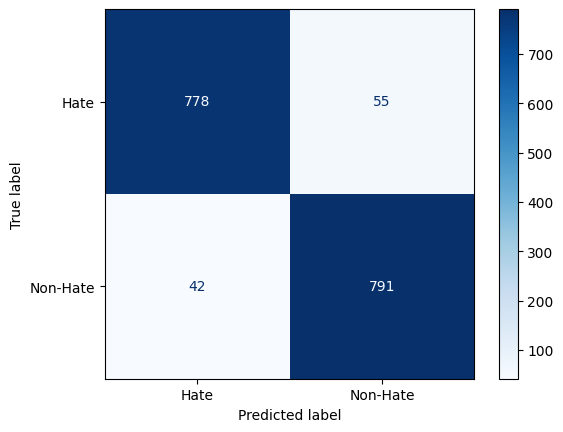

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix,ConfusionMatrixDisplay)
conf_matrix = confusion_matrix(y_test, y_pred)
from sklearn.metrics import (classification_report, confusion_matrix,
  ConfusionMatrixDisplay)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Hate', 'Non-Hate'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import joblib

# Save the model as a pickle in a file
joblib.dump(final_output, 'vector.pkl')

['vector.pkl']

## Train Model

In [ ]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepText', textProcessing()),
                ('vectorizer', CountVectorizer()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
y_pred = final_pipeline.predict(X_test)

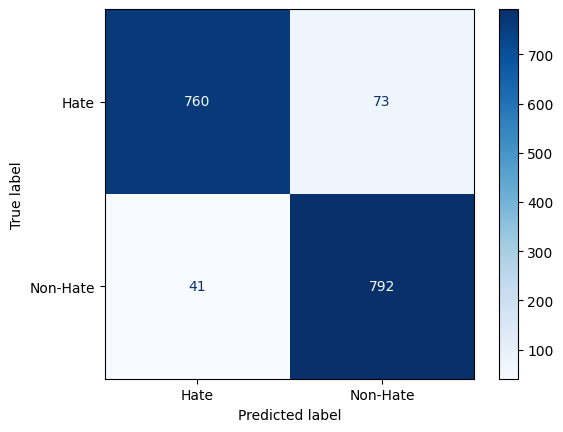

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix,ConfusionMatrixDisplay)
conf_matrix = confusion_matrix(y_test, y_pred)
from sklearn.metrics import (classification_report, confusion_matrix,
  ConfusionMatrixDisplay)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Hate', 'Non-Hate'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_pred)

0.915606936416185

In [ ]:
recall_score(y_test, y_pred)

0.9507803121248499

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.9328621908127208

## Export Trained Model:

In [ ]:
import joblib
joblib.dump(final_pipeline, 'content_tester.pkl')

['content_tester.pkl']

In [ ]:
import cloudpickle
with open('cloudier_tester.pkl', 'wb') as f:
    cloudpickle.dump(final_pipeline, f)

## Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(final_pipeline, X_train, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)

NameError: name 'ConfusionMatrixDisplay' is not defined

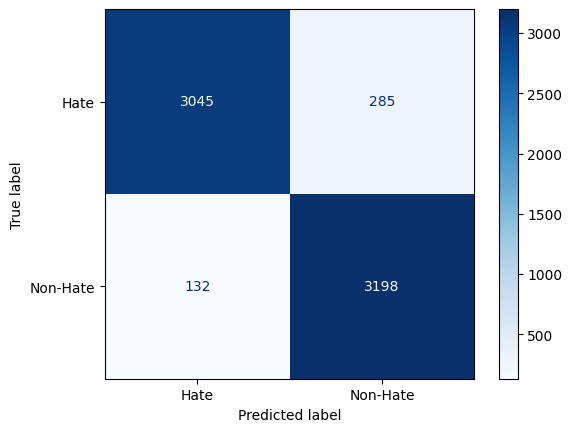

In [ ]:
from sklearn.metrics import (classification_report, confusion_matrix,
  ConfusionMatrixDisplay)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Hate', 'Non-Hate'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred)

0.9181739879414298

In [ ]:
recall_score(y_train, y_train_pred)

0.9603603603603603

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.9387934830471157